In [1]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 13.0 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import errno
%matplotlib inline
from datetime import datetime
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
import statsmodels.api as sm
import keras_tuner as kt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
plt.rcParams["figure.figsize"] = (15,10)

In [5]:
root = '/content/drive/MyDrive/Semester 5 - Project REAPS/Documents/6 sem/Code/Data/'
df = pd.read_csv(root+'corrected/west_bengal.csv')
datelist = df['DATE']
date_samples = datelist.sample(10)
df.describe()

,AIR_TEMP(°C),WIND_SPEED(m/s),ATMO_PRESSURE(hpa),HUMIDITY(%),RAIN_FALL(mm)
count,37986.000000,37986.000000,37986.000000,37986.000000,37986.000000
mean,17.097033,0.748586,772.302168,48.501975,79.912604
std,12.560400,0.685272,386.545716,30.677135,100.071925
min,-40.000000,0.000000,0.000000,0.000000,0.000000
25%,3.833333,0.000000,928.400000,23.433333,6.333333
50%,21.650000,0.675000,956.512500,57.445000,19.250000
75%,27.250000,1.300000,973.242143,74.372917,150.500000
max,31.700000,2.200000,1007.550000,88.700000,979.000000


In [128]:
cols = ['AIR_TEMP', 'WIND_SPEED', 'ATMO_PRESSURE', 'HUMIDITY', 'RAIN_FALL']
colname = ['AIR_TEMP(°C)', 'WIND_SPEED(m/s)', 'ATMO_PRESSURE(hpa)','HUMIDITY(%)', 'RAIN_FALL(mm)']
index = 2

In [129]:
df = pd.read_csv(root+'corrected/west_bengal.csv')
df['DATE']= pd.to_datetime(df['DATE'])

## Data split
Split the data into training and test set 

In [130]:
df = df.drop('DATE', 1)
training_set = df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [131]:
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)
sc_predict = StandardScaler()
sc_predict.fit_transform(training_set.iloc[:, index:index+1])
# sc = MinMaxScaler(feature_range=(0, 1))
# training_set_scaled = sc.fit_transform(training_set)

array([[-1.99798446],
       [-1.99798446],
       [-1.99798446],
       ...,
       [ 0.39503695],
       [ 0.39503695],
       [ 0.50032989]])

In [132]:
X_train = []
y_train = []

n_future = 1   
n_past = 60     

# 0 -> Air Temp
# 1 -> Wind speed
# 3 -> Atm Pressure
# 4 -> Humidity
# 5 -> Rainfall
for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:df.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, index])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (37926, 60, 5).
y_train shape == (37926, 1).


In [133]:
model = tf.keras.models.load_model(root+'ISRO_MODE/'+cols[index]+'.h5')

In [134]:
predictions_train = model.predict(X_train[n_past:])

In [135]:
y_pred_train = sc_predict.inverse_transform(predictions_train)
df['DATE'] = datelist

In [136]:
y_pred_train[0:].reshape(-1).shape

(37866,)

## Fine Tuning Mode

In [137]:
# def model_builder(hp):
#   scalar_model = tf.keras.Sequential()
#   scalar_model.add(tf.keras.layers.Flatten())
#   hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
#   scalar_model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
#   scalar_model.add(tf.keras.layers.Dense(50, activation='relu'))
#   scalar_model.add(tf.keras.layers.Dense(1, activation='relu'))
#   hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#   scalar_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                 loss='mse',
#                  metrics=['mae','mse','accuracy'])

#   return scalar_model

In [138]:
# train_X, test_X, train_y, test_y = train_test_split(y_pred_train[0:], df[2 * n_past + n_future -1:][colname[index]], random_state = 42)
# tuner = kt.Hyperband(model_builder,objective='val_loss',max_epochs=10,factor=3)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
# tuner.search(train_X, train_y, epochs=30, validation_split=0.2, callbacks=[stop_early])
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
# is {best_hps.get('learning_rate')}.
# """)

In [139]:
# model = tuner.hypermodel.build(best_hps)
# history = model.fit(train_X, train_y, epochs=20, validation_split=0.2)
# val_acc_per_epoch = history.history['val_accuracy']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))

In [140]:
# hypermodel = tuner.hypermodel.build(best_hps)
# hypermodel.fit(train_X, train_y, epochs=best_epoch, validation_split=0.2)
# eval_result = hypermodel.evaluate(test_X, test_y)
# print("[test loss, test accuracy]:", eval_result)

In [141]:
hypermodel = tf.keras.models.load_model(root+'ISRO_MODE/SCALERS/'+cols[index]+'.h5')
predictions = hypermodel.predict(y_pred_train[0:])

In [142]:
# hypermodel.save(root+'ISRO_MODE/SCALERS/'+cols[index]+'.h5')

In [143]:
try:
    os.makedirs(root+'ISRO_MODE/SCALERS/')
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Scalers Directory not created.')
    else:
        raise
try:
    os.makedirs(root+'ISRO_MODE/FINAL/')
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Final Directory not created.')
    else:
        raise

Scalers Directory not created.
Final Directory not created.


In [144]:
# "Loss"
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()
# plt.savefig(root+'ISRO_MODE/SCALERS/'+cols[index]+'.png')

In [145]:
PREDICTION_TRAIN = pd.DataFrame(predictions, columns=[colname[index]]).set_index(pd.Series(datelist[2 * n_past + n_future -1:]))
# PREDICTION_TRAIN['DATE'] = pd.Series(datelist[2 * n_past + n_future -1:])

(37866,)
(37866,)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

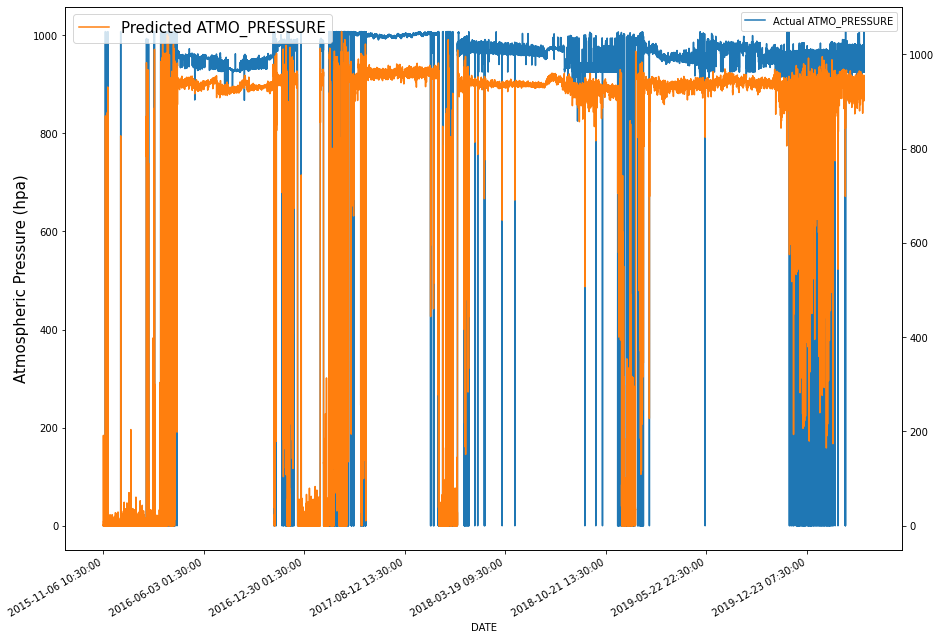

In [146]:
print(df[colname[index]][2 * n_past + n_future -1:].shape)
print(PREDICTION_TRAIN[colname[index]].shape)
ax = df.set_index('DATE')[colname[index]][2 * n_past + n_future -1:].plot()
plt.ylabel('Atmospheric Pressure (hpa)', fontsize = 15)
plt.legend(['Actual '+cols[index]])
PREDICTION_TRAIN[colname[index]].plot(secondary_y = True)
plt.legend(['Predicted '+cols[index]],loc = 2, fontsize = 15)
plt.xlabel('DATE', fontsize = 15)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
# plt.savefig(root+'ISRO_MODE/FINAL/'+cols[index]+'.png')

In [147]:
df_samples = pd.DataFrame(columns=['DATETIME', 'ACTUAL '+colname[index], 'PREDICTED '+colname[index], '% ERROR'])

In [148]:
df_samples

,DATETIME,ACTUAL ATMO_PRESSURE(hpa),PREDICTED ATMO_PRESSURE(hpa),% ERROR


In [149]:
print(date_samples)

22938    2018-07-15 08:30:00
19925    2018-03-11 06:30:00
18464    2018-01-09 05:30:00
34906    2019-12-12 12:30:00
37821    2020-04-23 22:30:00
10310    2017-01-06 23:30:00
31463    2019-07-18 07:30:00
20587    2018-04-07 20:30:00
14876    2017-08-02 06:30:00
14616    2017-07-22 04:30:00
Name: DATE, dtype: object


In [150]:
for x in date_samples:
  predic = PREDICTION_TRAIN.loc[x][colname[index]]
  act = df.loc[df['DATE'] == x][colname[index]].tolist()[0]
  err = ((predic - act)/act)*100
  df_samples.loc[len(df_samples.index)] = [x, act, predic, err] 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


In [151]:
df_samples

,DATETIME,ACTUAL ATMO_PRESSURE(hpa),PREDICTED ATMO_PRESSURE(hpa),% ERROR
0,2018-07-15 08:30:00,968.800000,945.287842,-2.426936
1,2018-03-11 06:30:00,965.833333,932.018188,-3.501137
2,2018-01-09 05:30:00,968.500000,943.374146,-2.594306
3,2019-12-12 12:30:00,965.275000,964.028687,-0.129115
4,2020-04-23 22:30:00,925.000000,933.058533,0.871193
5,2017-01-06 23:30:00,0.000000,7.958889,inf
6,2019-07-18 07:30:00,974.566667,931.718628,-4.396625
7,2018-04-07 20:30:00,963.866667,935.317993,-2.961890
8,2017-08-02 06:30:00,999.600000,973.477173,-2.613328
9,2017-07-22 04:30:00,996.500000,963.426514,-3.318965


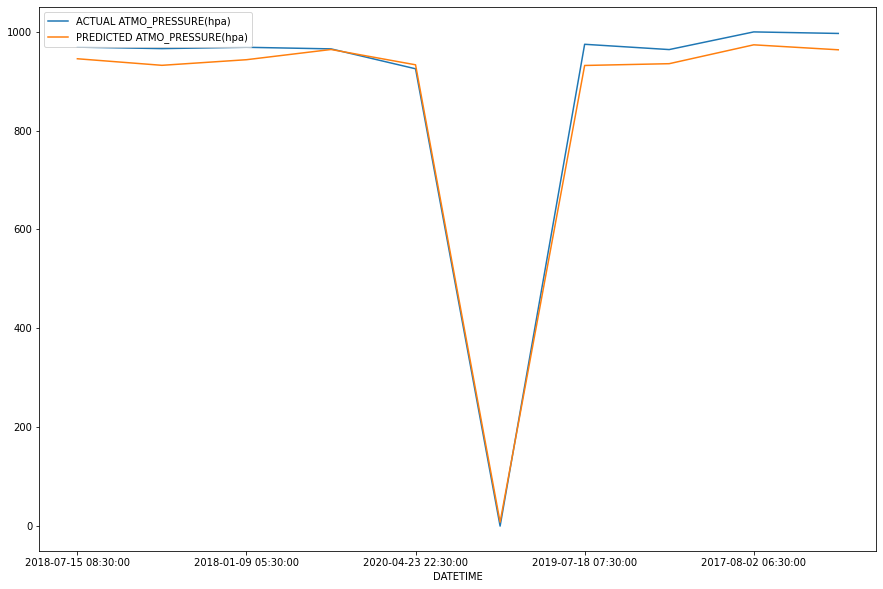

In [152]:
df_samples.set_index('DATETIME')[['ACTUAL '+colname[index], 'PREDICTED '+colname[index]]].plot()
# plt.savefig(root+'ISRO_MODE/FINAL/'+cols[index]+'_sample.png')

In [153]:
# df_samples.to_csv(root + 'isro_data.csv', mode='a', index=False, header=True)

In [154]:
saved_dataset = pd.DataFrame()
saved_dataset['DATETIME'] = pd.Series(datelist[2 * n_past + n_future -1:])
saved_dataset['ACTUAL'] = df[2 * n_past + n_future -1:][colname[index]]
saved_dataset['PREDICTED'] = pd.Series(PREDICTION_TRAIN[0:][colname[index]]).to_numpy()
saved_dataset['% ERROR'] = ((saved_dataset['PREDICTED'] - saved_dataset['ACTUAL'])/saved_dataset['ACTUAL'])*100
saved_dataset.describe()

,ACTUAL,PREDICTED,% ERROR
count,37866.000000,37866.000000,3.488500e+04
mean,774.749648,760.973572,inf
std,384.701032,357.292572,NaN
min,0.000000,0.000000,-1.000000e+02
25%,928.700000,911.863937,-3.558571e+00
50%,956.600000,934.267609,-2.380529e+00
75%,973.350000,943.992493,-8.410304e-01
max,1007.550000,1048.540527,inf


In [155]:
saved_dataset

,DATETIME,ACTUAL,PREDICTED,% ERROR
120,2015-11-06 10:30:00,0.00,0.851853,inf
121,2015-11-06 11:30:00,0.00,1.201796,inf
122,2015-11-06 12:30:00,0.00,1.810495,inf
123,2015-11-06 13:30:00,0.00,0.000000,NaN
124,2015-11-06 14:30:00,0.00,191.726440,inf
...,...,...,...,...
37981,2020-04-30 23:30:00,925.00,945.842041,2.253194
37982,2020-05-01 00:30:00,965.75,941.621948,-2.498375
37983,2020-05-01 01:30:00,925.00,947.796936,2.464534
37984,2020-05-01 02:30:00,925.00,946.268250,2.299270


In [156]:
# saved_dataset.to_csv(root+'ISRO_MODE/FINAL/'+cols[index]+'.csv', index=False, header=True)